In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import timedelta

['allenai_unifiedqa', 'cointegrated_rubert', 'csebuetnlp_banglat5', 'dandelin_vilt', 'alisawuffles_roberta', 'Davlan_multilingual', 'emrecan_bert', 'KB_bert', 'nbroad_ESG-BERT', 'SCUT-DLVCLab_lilt-roberta', 'ai-forever_sbert', 'amberoad_bert', 'Babelscape_rebel', 'castorini_msmarco', 'dccuchile_bert', 'DeepMount00_Llama', 'edumunozsala_roberta', 'Elron_bleurt', 'EmbeddedLLM_bge', 'eugenesiow_bart-paraphrase', 'facebook_hubert', 'facebook_roberta', 'facebook_mbart', 'facebook_xlm', 'google_muril', 'jinaai_jina', 'm3hrdadfi_typo-detector', 'microsoft_Orca', 'microsoft_phi-1', 'openai-community_openai', 'teknium_OpenHermes', 'uw-madison_mra-model', 'Efficient-Large-Model_VILA', 'dbmdz_bert', 'kuelumbus_polyBERT', 'bhadresh-savani', '1-800-BAD-CODE_XLM-ROBERTA', 'ai-forever_gpt', 'bayartsogt_albert', 'GroNLP_gpt', 'jhgan_ko-model', 'oliverguhr_fullstop', 'oliverguhr_german-sentiment', 'openai-community_gpt2', 'openai-community_roberta', 'Salesforce_ctrl', 'shibing624_text2vec', 'Babelscape

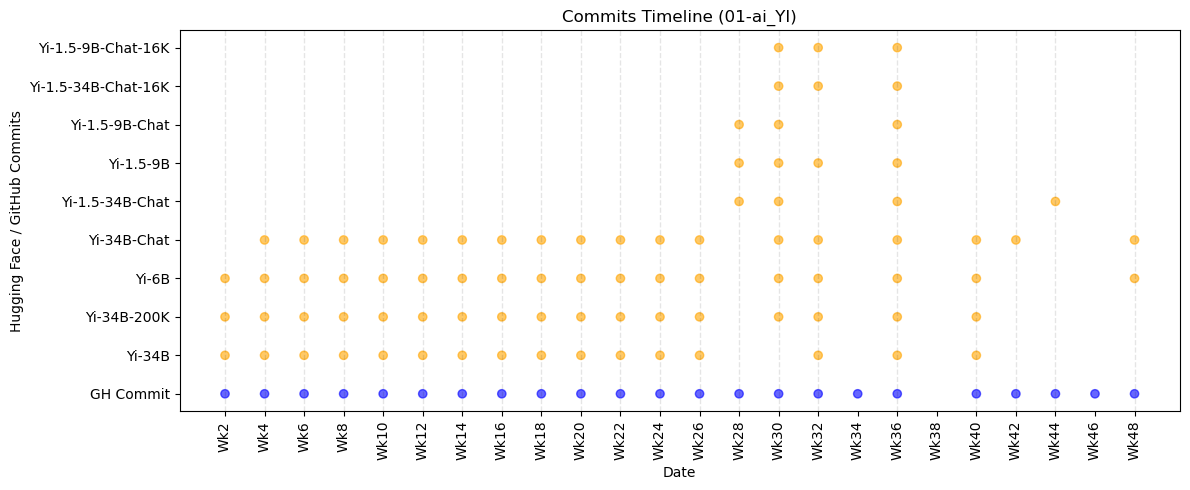

In [16]:
# File paths
file1 = "reduced_columns_GH_commit.csv"
file2 = "HF_commit_986.csv"
file3 = "manually_sampled_result.csv"

# Reading CSV files with latin1 encoding
GH_commit1 = pd.read_csv(file1, encoding='latin1')
HF_commit1 = pd.read_csv(file2, encoding='latin1')
families = pd.read_csv(file3, encoding='latin1')

GH_commit1 = GH_commit1[['owner', 'model_name', 'commit_date', 'family']]
HF_commit1 = HF_commit1[['owner', 'model_name', 'created_at', 'last_updated', 'date', 'family']]

family = list(families['family'].unique())
print(family)


def get_right_part(name):
    return name.split('/')[-1] if isinstance(name, str) else name


owners = ['01-ai_YI']


def filter_data_by_owner(owner, GH_commit1, HF_commit1):
    GH_commit = GH_commit1[GH_commit1["family"] == owner].copy()
    HF_commit = HF_commit1[HF_commit1['family'] == owner].copy()

    # Convert to datetime and handle missing values
    GH_commit['commit_date'] = pd.to_datetime(GH_commit['commit_date'], errors='coerce').dt.tz_localize(None)
    HF_commit['date'] = pd.to_datetime(HF_commit['date'], format='%m/%d/%Y', errors='coerce').dt.tz_localize(None)

    # Apply the function to HuggingFace data
    HF_commit['model_name'] = HF_commit['model_name'].apply(get_right_part)

    # For GitHub activities, add fixed labels
    GH_commit['model_name'] = 'GH Commit'

    # Combine the data
    commit_data = pd.concat([HF_commit[['date', 'model_name']],
                             GH_commit[['commit_date', 'model_name']].rename(columns={'commit_date': 'date'})],
                            ignore_index=True)
    return commit_data


# Function to set biweekly ticks
def set_biweekly_ticks(ax, data):
    start_date = data['date'].min()
    end_date = data['date'].max()
    num_biweeks = (end_date - start_date).days // 14 + 1
    ticks = [start_date + timedelta(days=i * 14) for i in range(num_biweeks)]
    ax.set_xticks(ticks)

    # Add dashed lines for each biweek only if both GH commit and variant commit exist in that biweek
    for tick in ticks:
        # Check if there are both GH commits and variant commits in the current biweek
        gh_commit_in_biweek = not data[(data['date'] >= tick) & (data['date'] < tick + timedelta(days=14)) & (
                    data['model_name'] == 'GH Commit')].empty
        variant_commit_in_biweek = not data[(data['date'] >= tick) & (data['date'] < tick + timedelta(days=14)) & (
                    data['model_name'] != 'GH Commit')].empty

        # Only add a dashed line if both types of commits exist in the biweek
        if gh_commit_in_biweek and variant_commit_in_biweek:
            ax.axvline(x=tick, color='black', linestyle='--', alpha=0.1, linewidth=1)  # Longer and lighter dashed lines

    week_labels = [f'Wk{i * 2 + 2}' for i in range(len(ticks))]  # Start from Week 2
    ax.set_xticklabels(week_labels, rotation=90)


# Function to plot the activity for each owner
def plot_activity(ax, data, title, y_label):
    data = data.dropna(subset=['date'])  # Ensure there are no missing date values
    if not data.empty:
        # Create custom biweekly periods
        min_date = data['date'].min()
        data['biweek'] = (data['date'] - min_date).dt.days // 14

        # Group data by biweek and model_name
        grouped_data = data.groupby(['biweek', 'model_name']).first().reset_index()

        # Calculate the start date for each biweek
        grouped_data['biweek_start'] = min_date + pd.to_timedelta(grouped_data['biweek'] * 14, unit='D')

        colors = grouped_data['model_name'].apply(lambda x: 'blue' if x == 'GH Commit' else 'orange')
        ax.scatter(grouped_data['biweek_start'], grouped_data['model_name'], color=colors, alpha=0.6)
        ax.set_title(title)
        ax.set_ylabel(y_label)
        set_biweekly_ticks(ax, data)  # Set the ticks and dashed lines only where needed
    else:
        ax.set_title(title)
        ax.set_ylabel(y_label)
        ax.set_xticks([])  # Remove x-ticks for empty plots


# Plot for each owner
for owner in owners:
    commit_data = filter_data_by_owner(owner, GH_commit1, HF_commit1)

    fig, ax = plt.subplots(figsize=(12, 5))  # Create one plot per owner with one row
    plot_activity(ax, commit_data, f'Commits Timeline ({owner})', 'Hugging Face / GitHub Commits')

    ax.set_xlabel('Date')  # Set x-axis label

    plt.tight_layout()

    # Save the figure
    #save_path = f"I:/Paper2/PAPER2_experiment_steps/NLP/Experiment_for_top_models/all_dataset/sampled_families/manual_label_analysis/all_figures/{owner}_commits_timeline.png"
    #plt.savefig(save_path)  # Save each figure with the owner's name
    plt.show()

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.dates import DateFormatter
import numpy as np


def check_activity_lead(commit_data):
    # Drop rows with missing dates
    commit_data = commit_data.dropna(subset=['date'])

    if commit_data.empty:
        return "No Data"

    # Calculate biweekly periods
    min_date = commit_data['date'].min()
    commit_data['biweek'] = ((commit_data['date'] - min_date).dt.days // 14 + 1)  # Periods are 2, 4, 6, etc.

    # Pivot table to see activities for each period and source
    pivot = commit_data.pivot_table(index='biweek', columns='model_name', values='date', aggfunc='first').notna()

    # Iterate through periods in ascending order
    for biweek in sorted(pivot.index):
        gh_activity = pivot.at[biweek, 'GH Commit'] if 'GH Commit' in pivot.columns else False
        variant_activity = pivot.drop('GH Commit', axis=1, errors='ignore').any(axis=1).loc[biweek]

        if gh_activity and variant_activity:
            return "Simultaneous"  # Both have activity in the same biweek
        elif gh_activity and not variant_activity:
            return "GitHub First"  # GitHub has activity but variant does not
        elif variant_activity and not gh_activity:
            return "Hugging Face First"  # Variant has activity but GitHub does not

    # Default return if no clear lead is found
    return "No Data"


def synchronization(commit_data):
    # Drop rows with missing dates
    commit_data = commit_data.dropna(subset=['date'])

    if commit_data.empty:
        return "No Data"

    # Calculate biweekly periods
    min_date = commit_data['date'].min()
    commit_data['biweek'] = ((commit_data['date'] - min_date).dt.days // 14)

    # Separate GitHub and Variant activities
    github_periods = commit_data.loc[commit_data['model_name'] == 'GH Commit', 'biweek'].unique()
    variants = commit_data.loc[commit_data['model_name'] != 'GH Commit', 'model_name'].unique()

    # Check for complete overlap (CS)
    all_variants_overlap = True
    for variant in variants:
        variant_periods = commit_data.loc[commit_data['model_name'] == variant, 'biweek'].unique()
        if not set(variant_periods).issubset(github_periods):
            all_variants_overlap = False
            break

    if all_variants_overlap:
        return "CS"

    # Check for partial overlap (PS)
    variant_periods = commit_data.loc[commit_data['model_name'] != 'GH Commit', 'biweek'].unique()
    overlap_periods = set(variant_periods).intersection(github_periods)
    if overlap_periods:
        return "PS"

    # Check for variant dominance (VS)
    variant_counts_by_period = (
        commit_data[commit_data['model_name'] != 'GH Commit']
        .groupby('biweek')['model_name']
        .nunique()
    )  # Count unique variants in each period

    # Identify periods with at least 3 unique variants
    periods_with_three_or_more_variants = variant_counts_by_period[variant_counts_by_period >= 3]

    # If there are at least 3 such periods, return "VS"
    if len(periods_with_three_or_more_variants) >= 3:
        return "VS"

    # Default case (AS)
    return "AS"


def intensity(commit_data):
    # Drop rows with missing dates
    commit_data = commit_data.dropna(subset=['date'])

    if commit_data.empty:
        return "No Data"

    # Calculate biweekly periods
    min_date = commit_data['date'].min()
    commit_data['biweek'] = ((commit_data['date'] - min_date).dt.days // 14)

    # Separate GitHub and Variant activities
    github_periods = commit_data.loc[commit_data['model_name'] == 'GH Commit', 'biweek'].unique()
    variants = commit_data.loc[commit_data['model_name'] != 'GH Commit', 'model_name'].unique()

    # Ensure every variant's activity spans <=3 biweekly periods
    for variant in variants:
        variant_periods = commit_data[commit_data['model_name'] == variant]['biweek'].unique()
        print(variant_periods)
        if len(variant_periods) > 3:
            break  # If any variant exceeds the threshold, skip "R" condition
    else:
        # Only executed if all variants satisfy the condition
        return "R"

    # Check if there are 5 consecutive overlapping periods
    for variant in variants:
        # Get the periods for the current variant
        variant_periods = commit_data[commit_data['model_name'] == variant]['biweek'].unique()

        # Get the overlapping periods between the variant and GitHub
        overlap_periods = sorted(set(variant_periods).intersection(github_periods))

        # If no overlap exists, continue to the next variant
        if not overlap_periods:
            continue

        # Check for 5 consecutive overlaps (with no gaps in between)
        consecutive_count = 1  # Initialize count of consecutive periods
        last_overlap = overlap_periods[0]  # Start with the first overlap period

        for i in range(1, len(overlap_periods)):
            current_overlap = overlap_periods[i]

            # Check if the current overlap is exactly 1 biweek after the previous overlap
            if current_overlap == last_overlap + 1:
                consecutive_count += 1
            else:
                consecutive_count = 1  # Reset if there is a gap

            # If 5 consecutive periods are found, return "F"
            if consecutive_count >= 5:
                return "F"

            last_overlap = current_overlap  # Update the last_overlap to the current one

    # If no 5 consecutive overlaps, return "S"
    return "S"

In [21]:
#from functions_for_detection import *
import warnings
warnings.simplefilter("ignore", category=UserWarning)
from sklearn.metrics import cohen_kappa_score

# File paths
file1 = "reduced_columns_GH_commit.csv"
file2 = "HF_commit_986.csv"
file3 = "unique_sample_families.csv"


# Reading CSV files with latin1 encoding
GH_commit1 = pd.read_csv(file1, encoding='latin1')
HF_commit1 = pd.read_csv(file2, encoding='latin1')

families = pd.read_csv(file3, encoding='latin1')

GH_commit1 = GH_commit1[['owner', 'github', 'model_name', 'commit_date', 'family']]
HF_commit1 = HF_commit1[['owner', 'model_name', 'created_at', 'last_updated', 'date', 'family']]

def get_right_part(name):
    return name.split('/')[-1] if isinstance(name, str) else name

sampled_families = families['family'].unique()



remaining_GH = GH_commit1[GH_commit1['family'].isin(sampled_families)]
remaining_HF = HF_commit1[HF_commit1['family'].isin(sampled_families)]

def filter_data_by_owner(owner, GH_commit1, HF_commit1):
    GH_commit = remaining_GH[remaining_GH["family"] == owner].copy()
    HF_commit = remaining_HF[remaining_HF['family'] == owner].copy()

    # Convert to datetime and handle missing values
    GH_commit['commit_date'] = pd.to_datetime(GH_commit['commit_date'], errors='coerce').dt.tz_localize(None)
    HF_commit['date'] = pd.to_datetime(HF_commit['date'], format='%m/%d/%Y', errors='coerce').dt.tz_localize(None)

    # Apply the function to HuggingFace data
    HF_commit['model_name'] = HF_commit['model_name'].apply(get_right_part)

    # For GitHub activities, add fixed labels
    GH_commit['model_name'] = 'GH Commit'

    # Combine the data
    commit_data = pd.concat([HF_commit[['date', 'model_name']],
                             GH_commit[['commit_date', 'model_name']].rename(columns={'commit_date': 'date'})],
                            ignore_index=True)
    return commit_data

owners = list(remaining_HF['family'].unique())[50:55]


owner_sampled = sampled_families


family = []
lag = []
sync = []
asynchronous = []
intensities = []



for owner in owners:
    commit_data = filter_data_by_owner(owner, remaining_GH, remaining_HF)
    lagged = check_activity_lead(commit_data)
    syncs = synchronization(commit_data)
    intenses = intensity(commit_data)

    family.append(owner)
    lag.append(lagged)
    sync.append(syncs)
    intensities.append(intenses)

    #print(commit_overlap)

output_data = pd.DataFrame({'family': family,
                            'Lagged': lag,
                            'Syncs': sync,
                            'intensity': intensities
})#.reset_index()

# Save to CSV
#output_data.to_csv('I:/Paper2/PAPER2_experiment_steps/NLP/Experiment_for_top_models/all_dataset/sampled_families/results/confirmations.csv', index=None)

#print("Data has been successfully saved to 'family_horizontal_data.csv'.")
print(output_data)



[15 13 11]
[5]
[40  0]
[72 60 54 42 41 34 27 20 18 17 16 13  8]
[187 183 154 149 114  93  91  88  85]
                       family              Lagged Syncs intensity
0      EmergentMethods_gliner        GitHub First    PS         R
1                emrecan_bert        GitHub First    CS         R
2  eugenesiow_bart-paraphrase  Hugging Face First    AS         R
3               facebook_bart  Hugging Face First    VS         S
4         facebook_blenderbot        GitHub First    PS         S


In [22]:
file1 = "../complete_dataset.csv"
file2 = "../must_exclude_from_all_analysis.csv"


dataset = pd.read_csv(file1, encoding='latin1')
exclude = pd.read_csv(file2, encoding='latin1')

exclusion = list(exclude['family'].unique())


df = dataset[~dataset['family'].isin(exclusion)]
df

,owner,model_name,family,downloads,likes,created_at_main,last_modified_main,age,adoption,library_name,...,codes,Lagged,pattern_names,names,first_created,last_modified,first_commits,last_commits,age_days_individual_x,average_age_days
0,google-bert,google-bert/bert-base-uncased,google-bert_bert,67352152,1618,3/2/2022,2/19/2024,903,74587.100780,transformers,...,PSS,Upstream First,Dispersed Alignment Pattern,Dispersed Alignment,2022-03-02 23:29:04+00:00,2024-02-19 11:06:12+00:00,2018-11-14 23:35:08+00:00,2024-02-19 11:06:12+00:00,1922,1811.230769
1,facebook,facebook/fasttext-language-identification,facebook_fasttext,52552566,120,4/6/2022,1/24/2023,868,60544.430880,fasttext,...,PSR,Upstream First,Sparse Alignment Pattern,Sparse Alignment,2023-03-06 12:52:50+00:00,2023-06-09 12:39:43+00:00,2023-03-06 12:52:50+00:00,2023-06-09 12:39:43+00:00,94,94.000000
2,distilbert,distilbert/distilbert-base-uncased,distilbert_distilbert,30382216,444,3/2/2022,12/19/2023,903,33645.864890,transformers,...,CSS,Upstream First,Intermittent Alignment Pattern,Intermittent Alignment,2022-03-02 23:29:04+00:00,2024-05-06 13:44:53+00:00,2019-08-28 12:31:11+00:00,2024-05-06 13:44:53+00:00,1713,1603.000000
7,cardiffnlp,cardiffnlp/twitter-roberta-base-sentiment-latest,cardiffnlp_tweeteval,11244103,452,8/2/2022,1/10/2023,750,14992.137330,transformers,...,PSS,Upstream First,Dispersed Alignment Pattern,Dispersed Alignment,2022-03-15 01:21:58+00:00,2023-05-28 05:45:10+00:00,2022-03-15 01:21:58+00:00,2023-05-28 05:45:10+00:00,439,628.200000
8,nomic-ai,nomic-ai/nomic-embed-text-v1.5,nomic-ai_nomic,10974960,237,2/10/2024,8/1/2024,193,56865.077720,sentence-transformers,...,PSS,Downstream First,Dispersed Alignment Pattern,Dispersed Alignment,2024-02-10 06:32:35+00:00,2024-11-18 20:39:44+00:00,2024-02-10 06:32:35+00:00,2024-11-18 20:39:44+00:00,282,221.750000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
981,jinaai,jinaai/jina-embeddings-v2-base-es,jinaai_jina,10135,17,1/24/2024,8/6/2024,210,48.261905,sentence-transformers,...,ASS,Upstream First,Sporadic Disjoint Pattern,Sporadic Disjoint,2024-01-24 09:54:03+00:00,2024-08-06 14:41:45+00:00,2024-01-24 09:54:03+00:00,2024-08-06 14:41:45+00:00,195,203.285714
982,bigscience,bigscience/mt0-base,bigscience_workshop,10125,25,8/7/2022,2/10/2023,745,13.590604,transformers,...,PSF,Upstream First,Dense Partial Alignment Pattern,Dense Partial Alignment,2022-10-27 19:21:27+00:00,2023-09-26 09:17:05+00:00,2022-10-27 19:21:27+00:00,2023-09-26 09:17:05+00:00,333,436.000000
983,MoritzLaurer,MoritzLaurer/deberta-v3-large-zeroshot-v1,MoritzLaurer_DeBERTa,10123,19,9/29/2023,11/29/2023,327,30.957187,transformers,...,PSS,Downstream First,Dispersed Alignment Pattern,Dispersed Alignment,2023-10-03 03:24:13+00:00,2023-11-29 19:30:53+00:00,2023-10-03 03:24:13+00:00,2023-11-29 19:30:53+00:00,57,492.500000
984,shhossain,shhossain/opus-mt-en-to-bn,shhossain_opus-mt,10045,2,8/21/2023,8/23/2023,366,27.445355,transformers,...,PSR,No Lag,Sparse Alignment Pattern,Sparse Alignment,2023-08-26 12:17:37+00:00,2024-02-03 18:52:29+00:00,2023-08-26 12:17:37+00:00,2024-02-03 18:52:29+00:00,161,161.000000


In [33]:
import pandas as pd
from scipy.stats import chi2_contingency
import ast

# Load the datasets
file1 = "../RQ1/GH_labelled_with_patterns.csv"
file2 = "../RQ1/HF_labelled_with_patterns_authors.csv"
f2 = "../RQ1/must_exclude_from_all_analysis.csv"

df_gh = pd.read_csv(file1, encoding='latin1')
df_hf = pd.read_csv(file2, encoding='latin1')
dfs2 = pd.read_csv(f2, encoding='latin1')

HF1 = df_hf[df_hf['author_HF'] != "No_GH"]

exclusion = list(dfs2['family'].unique())

GH = df_gh[~df_gh['family'].isin(exclusion)]
HF = HF1[~HF1['family'].isin(exclusion)]

gh = GH.groupby("family").agg({
    'author_GH': 'unique'
}).reset_index()

hf = HF.groupby("family").agg({
    'author_HF': 'unique'
}).reset_index()

def string_to_list(x):
    if isinstance(x, str):
        try:
            return ast.literal_eval(x)
        except (SyntaxError, ValueError):
            return []
    return x

# Apply the function to ensure that the author columns contains list
gh['author_GH'] = gh['author_GH'].apply(string_to_list)
hf['author_HF'] = hf['author_HF'].apply(string_to_list)

merged = pd.merge(hf, gh,  on="family", how="inner")

# Extract three families, their authors, and common authors
sample_families = merged  # Select the first three families
family_data = []

for _, row in sample_families.iterrows():
    family_name = row['family']
    authors_gh = set(row['author_GH'])  # Convert to set for comparison
    authors_hf = set(row['author_HF'])
    common_authors = list(authors_hf.intersection(authors_gh))  # Find common authors

    family_data.append({
        "family": family_name,
        "authors_GH": list(authors_gh),
        "authors_HF": list(authors_hf),
        "common_authors": common_authors
    })

# Convert to a DataFrame for easy display
result_df = pd.DataFrame(family_data)
result_df['common_authors_count'] = result_df['common_authors'].apply(len)
#result_df['total'] = lambda x: x in result_df['common_authors']

# Print results
print("\nSample Families with Authors from GH and HF and Their Common Authors:")
result_df

# Optionally, save results to CSV
#result_df.to_json("I:/Paper2/PAPER2_experiment_steps/NLP/Experiment_for_top_models/all_dataset/sampled_families/results/RQ_datas/RQ3_dataset/family_author_comparison.json", index=False)


#print(gh)
#print(hf)





Sample Families with Authors from GH and HF and Their Common Authors:


,family,authors_GH,authors_HF,common_authors,common_authors_count
0,01-ai_YI,"[https://github.com/markli404, https://github....","[https://github.com/findmyway, https://github....","[https://github.com/Anonymitaet, https://githu...",4
1,1-800-BAD-CODE_XLM-ROBERTA,"[https://github.com/Unknown, https://github.co...",[https://github.com/1-800-BAD-CODE],[https://github.com/1-800-BAD-CODE],1
2,42dot_42DOT-LLM,"[https://github.com/blueworm7, https://github....",[https://github.com/wangcho2k],[],0
3,AnnaWegmann_Style-Embedding,"[https://github.com/Unknown, https://github.co...",[https://github.com/AnnaWegmann],[https://github.com/AnnaWegmann],1
4,BAAI_bge,"[https://github.com/luisegarduno, https://gith...","[https://github.com/shunxing1234, https://gith...","[https://github.com/ftgreat, https://github.co...",2
...,...,...,...,...,...
301,wukevin_tcr-bert,"[https://github.com/wukevin, https://github.co...",[https://github.com/wukevin],[https://github.com/wukevin],1
302,wxjiao_alpaca,[https://github.com/wxjiao],[https://github.com/wxjiao],[https://github.com/wxjiao],1
303,xlnet_xlnet,"[https://github.com/kimiyoung, https://github....","[https://github.com/julien-c, https://github.c...",[],0
304,yahma_llama,"[https://github.com/vinnymeller, https://githu...",[https://github.com/gururise],[],0


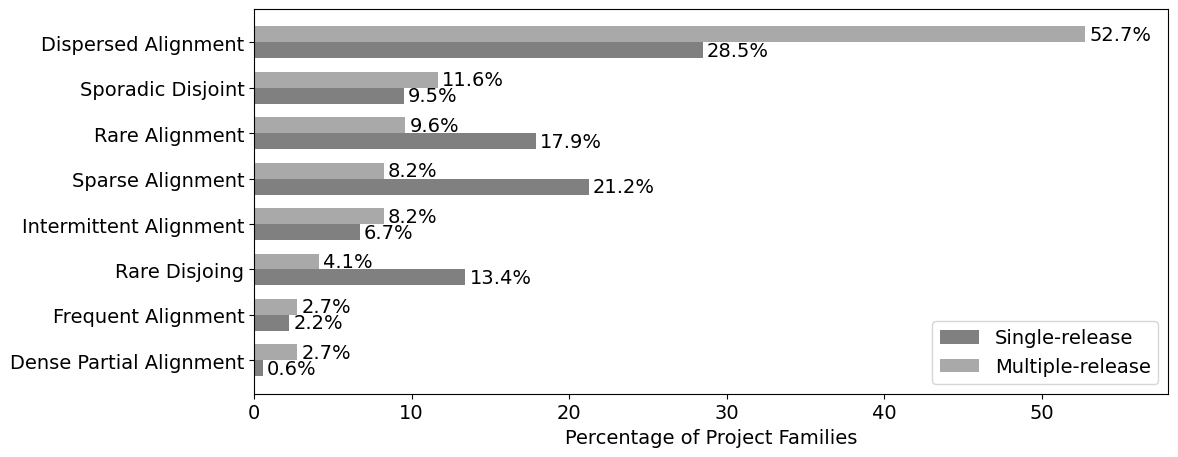

In [26]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Set the font size globally
plt.rcParams.update({'font.size': 14})

# Your existing code remains unchanged up to this point

fig, ax = plt.subplots(figsize=(12, len(sorted_names) * 0.6))  # Adjust figure size

x = np.arange(len(sorted_names))
width = 0.35

# Plot bars
rects1 = ax.barh(x - width/2, release_percentages.loc[sorted_names, 'Single-release'], width, label='Single-release', color='gray')
rects2 = ax.barh(x + width/2, release_percentages.loc[sorted_names, 'Multiple-release'], width, label='Multiple-release', color='darkgray')

# Customize the chart
ax.set_xlabel('Percentage of Project Families', fontsize=14)
ax.set_yticks(x)
ax.set_yticklabels(sorted_names, fontsize=14)
ax.legend(fontsize=14)

# Add percentage labels on top of the bars
def autolabel(rects):
    for rect in rects:
        width = rect.get_width()
        ax.annotate(f'{width:.1f}%',
                    xy=(width, rect.get_y() + rect.get_height()/2),
                    xytext=(3, 0),  # 3 points horizontal offset
                    textcoords="offset points",
                    ha='left', va='center',
                    fontsize=14)

autolabel(rects1)
autolabel(rects2)

# Adjust x-axis limits to accommodate the longest bar and its label
x_max = max(release_percentages['Single-release'].max(), release_percentages['Multiple-release'].max())
ax.set_xlim(0, x_max * 1.1)  # Add 10% extra space

plt.tight_layout()
plt.savefig("argument3_1.pdf", bbox_inches='tight')
plt.show()


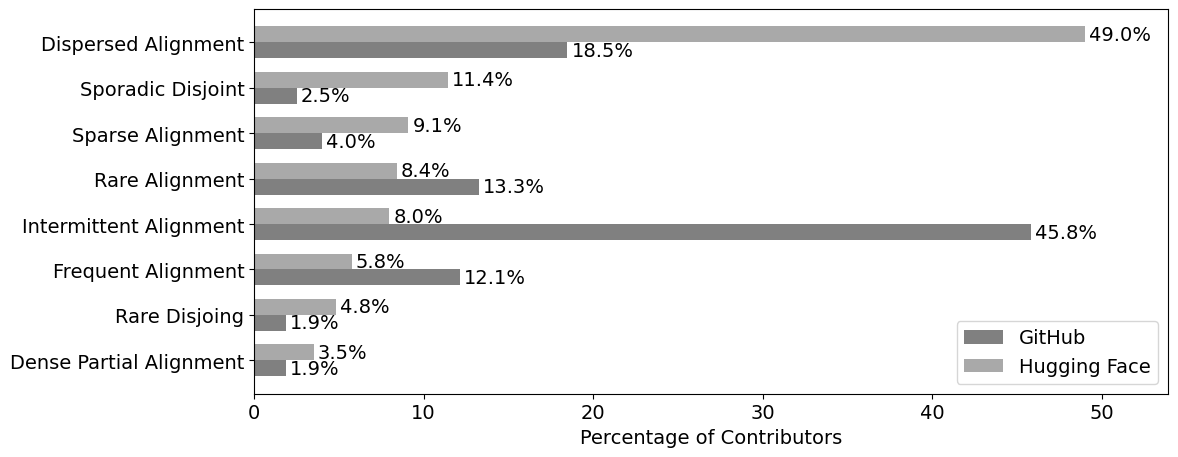

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

file1 = "../RQ1/GH_labelled_with_patterns.csv"
file2 = "../RQ1/HF_labelled_with_patterns_authors.csv"
f2 = "../must_exclude_from_all_analysis.csv"

gh = pd.read_csv(file1, encoding='latin1')
hf = pd.read_csv(file2, encoding='latin1')
exclude = pd.read_csv(f2, encoding='latin1')

exclusion = list(exclude['family'].unique())

GH1 = gh[~gh['family'].isin(exclusion)]
HF1 = hf[~hf['family'].isin(exclusion)]

group_gh = GH1.groupby(["owner", "family"]).agg({
    'author_username': "nunique"
}).reset_index()

GH = pd.merge(group_gh, grouping, on='family', how='inner')

group_hf = HF1.groupby(["owner", "family"]).agg({
    'author': "nunique"
}).reset_index()

HF = pd.merge(group_hf, grouping, on='family', how='inner')

gh_authors = GH.groupby('names')['author_username'].sum().reset_index()
hf_authors = HF.groupby('names')['author'].sum().reset_index()

# Calculate percentages for each platform separately
gh_authors['gh_percentage'] = gh_authors['author_username'] / gh_authors['author_username'].sum() * 100
hf_authors['hf_percentage'] = hf_authors['author'] / hf_authors['author'].sum() * 100

# Merge the data
merged_data = pd.merge(gh_authors[['names', 'gh_percentage']], hf_authors[['names', 'hf_percentage']], on='names')

# Sort by GitHub percentage
merged_data = merged_data.sort_values('hf_percentage', ascending=True)

# Increase font size to 14
plt.rcParams.update({'font.size': 14})

# Create the plot
fig, ax = plt.subplots(figsize=(12, len(merged_data) * 0.6))

x = np.arange(len(merged_data['names']))
width = 0.35

# Plot bars
rects1 = ax.barh(x - width/2, merged_data['gh_percentage'], width, label='GitHub', color='gray')
rects2 = ax.barh(x + width/2, merged_data['hf_percentage'], width, label='Hugging Face', color='darkgray')

# Customize the chart
ax.set_xlabel('Percentage of Contributors', fontsize=14)
ax.set_yticks(x)
ax.set_yticklabels(merged_data['names'], fontsize=14)
ax.legend(fontsize=14)

# Add percentage labels on top of the bars
def autolabel(rects):
    for rect in rects:
        width = rect.get_width()
        ax.annotate(f'{width:.1f}%',
                    xy=(width, rect.get_y() + rect.get_height()/2),
                    xytext=(3, 0),  # 3 points horizontal offset
                    textcoords="offset points",
                    ha='left', va='center',
                    fontsize=14)

autolabel(rects1)
autolabel(rects2)

# Set x-axis limit to ensure all labels are visible
max_percentage = max(merged_data['gh_percentage'].max(), merged_data['hf_percentage'].max())
ax.set_xlim(0, max_percentage * 1.1)  # Add 10% extra space

# Update font sizes for specific elements
ax.tick_params(axis='both', which='major', labelsize=14)

plt.tight_layout()
plt.savefig("argument3_2.pdf", bbox_inches='tight')
plt.show()


Chi-square statistic: 1321.663716814159
P-value: 3.425036874877538e-281
The synchronization patterns are statistically different (reject the null hypothesis).


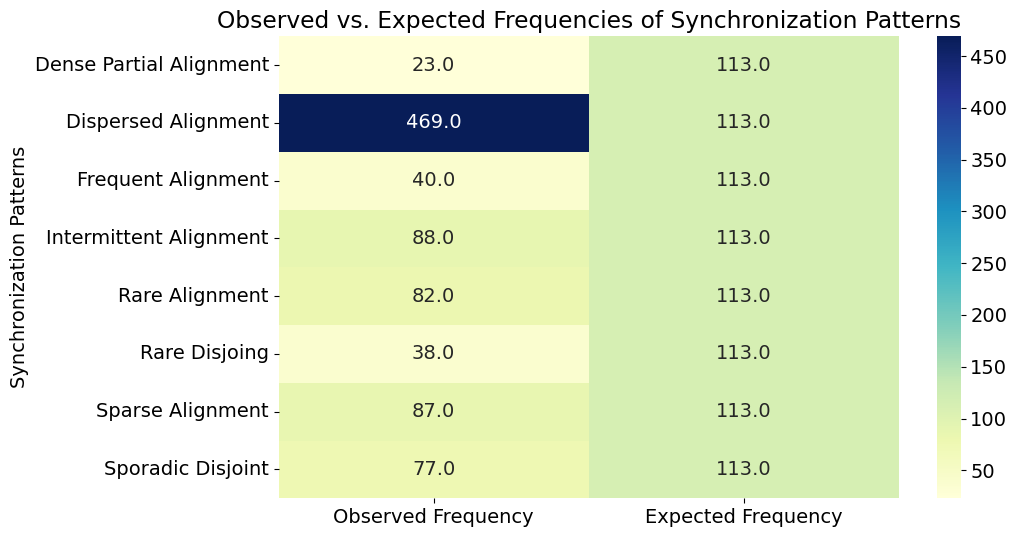

In [40]:
import pandas as pd
from scipy.stats import chisquare
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load the data
file1 = "../RQ1/complete_dataset.csv"  
f2 = "../must_exclude_from_all_analysis.csv"

df1 = pd.read_csv(file1, encoding='latin1')
exclude = pd.read_csv(f2, encoding='latin1')

exclusion = list(exclude['family'].unique())

df = df1[~df1['family'].isin(exclusion)]

pattern_name = df['names']

# Calculate observed frequencies
observed_frequencies = pattern_name.value_counts().sort_index()

# Calculate expected frequencies (uniform distribution)
expected_frequency = len(pattern_name) / len(observed_frequencies)
expected_frequencies = np.full(len(observed_frequencies), expected_frequency)

# Perform chi-square goodness-of-fit test
chi2, p = chisquare(observed_frequencies, expected_frequencies)

# Print the results
print("Chi-square statistic:", chi2)
print("P-value:", p)

# Interpret the results
alpha = 0.05  # Significance level

if p < alpha:
    print("The synchronization patterns are statistically different (reject the null hypothesis).")
else:
    print("The synchronization patterns are not statistically different (fail to reject the null hypothesis).")

# Visualize observed and expected frequencies using a heatmap
observed_df = pd.DataFrame({'Pattern': observed_frequencies.index, 'Observed Frequency': observed_frequencies.values})
expected_df = pd.DataFrame({'Pattern': observed_frequencies.index, 'Expected Frequency': expected_frequencies})

merged_df = pd.merge(observed_df, expected_df, on='Pattern')
merged_df = merged_df.set_index('Pattern')

plt.figure(figsize=(10, 6))
sns.heatmap(merged_df, annot=True, fmt=".1f", cmap="YlGnBu")
plt.title("Observed vs. Expected Frequencies of Synchronization Patterns")
plt.ylabel("Synchronization Patterns")
plt.show()

# Replication Package:
# The python script that was used is included in the replication package.
# (Add information on where the replication package is located, or how to access it.)

In [43]:
print(merged_df.reset_index())

                   Pattern  Observed Frequency  Expected Frequency
0  Dense Partial Alignment                  23               113.0
1      Dispersed Alignment                 469               113.0
2       Frequent Alignment                  40               113.0
3   Intermittent Alignment                  88               113.0
4           Rare Alignment                  82               113.0
5            Rare Disjoing                  38               113.0
6         Sparse Alignment                  87               113.0
7        Sporadic Disjoint                  77               113.0
